In [82]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import pandas as pd
from skimage.io import imread
from skimage.transform import resize
import os
import PIL
from PIL import Image
from torchvision import models
import torch.optim as optim
import torch.nn as nn
import time
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

# Гиперпараметры

In [21]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(size=(224,224), antialias = True),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64
test_size = 0.2

ROOT = '/content/drive/MyDrive/Учеба/Мага 1 курс 2 сем/Нейронные сети/Лаб4/'
NET_NAME_1 = 'net_1.pt'
DATASET_FOLDER = 'dataset'
DATASET_CLASES = 'train.csv'
DATA_ROOT = ROOT + DATASET_FOLDER

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
def save_model(model, path, name):
  model_scripted = torch.jit.script(model)
  model_scripted.save(path + name)

In [44]:
def imshow(img):
    img = img  / 2  + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [10]:
def fit(model, train_dataloader, optim, criterion):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        images, labels = data[0].to(DEVICE), data[1].to(DEVICE)

        optim.zero_grad()
        output = model(images)

        loss = criterion(output, labels)
        train_running_loss += loss.item()
        loss.backward()
        optim.step()

        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == labels).sum().item()
        if i*batch_size % 300 == 0 :
          print(i*batch_size, '/', len(train_dataloader.dataset), ': loss = ', loss.item())
        
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%')
    
    return train_loss, train_accuracy

In [11]:
def my_accuracy(net, test_loader):
  correct = 0
  total = 0
  # поскольку мы не обучаемся, нам не нужно вычислять градиенты для наших выходов
  with torch.no_grad():
      for data in test_loader:
          images, labels = data[0].to(DEVICE), data[1].to(DEVICE)
          # рассчитываем выходные данные, пропуская изображения через сеть
          outputs = net(images)
          # класс с наибольшей мощностью - это то, что мы выбираем в качестве предсказания
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the test images: {100 * correct // total} %')
  return 100 * correct // total

In [36]:
def IndexToClass(i):
  return i+1
def ClassToIndex(c):
  return c-1

In [78]:
df = pd.read_csv(ROOT+DATASET_CLASES).reset_index(drop=True)
df = df.rename({'image': 'name', 'Class' : 'label'}, axis=1)

data = pd.DataFrame(columns = ['X','Y'])

# for i in range(0, len(df)) :
for i in range(0, 500) :
    image = Image.open(os.path.join(DATA_ROOT, df['name'][i]))
    if len(image.getbands()) == 1:
        image = transforms.Grayscale(3)(image)
    image = transform(image)
    data = data.append({'X':image,'Y':ClassToIndex(df['label'][i])}, ignore_index = True)
    if (i+1) % 250 == 0:
      print(i+1,"/",len(df))

250 / 7000
500 / 7000


In [79]:
def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

In [80]:
X, y = feature_label_split(data, 'Y')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [87]:
X_train.to_numpy()
train_features = torch.Tensor(X_train.to_numpy())
train_targets = torch.Tensor(X_test)
test_features = torch.Tensor(y_train)
test_targets = torch.Tensor(y_test)

TypeError: ignored

In [83]:
train = TensorDataset(X_train, y_train)
test = TensorDataset(X_test, y_test)

TypeError: ignored

In [ ]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

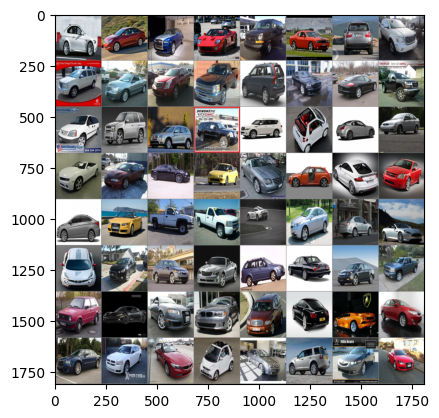

tensor([184,  71, 106,  73,  76, 117, 172,  99,  99, 122, 189, 159, 131,  33,
         41,  57, 108, 114,  75,  21,  35, 134, 136, 169,  63, 185,  19, 123,
        175,  14,  39,  29,  98, 125, 147, 159,  26,   1, 163, 133,  22, 129,
         58, 175, 186,  95,   1,  78,  37,  94, 105,  88,  96,  42, 143,  53,
         19, 180,  32, 134, 174,  97,  58, 110])


In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(labels)

#VGG16

In [ ]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(DEVICE)
print(vgg16)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# меняем число выходов
vgg16.classifier[6].out_features = len(CLASSES)

# замораживаем веса сверточных слоев
for param in vgg16.features.parameters():
    param.requires_grad = False

In [ ]:
# optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()
max_epochs = 5

In [ ]:
train_loss , train_accuracy = [], []
start = time.time()

for epoch in range(max_epochs):
    print("epoch - ", epoch)
    train_epoch_loss, train_epoch_accuracy = fit(vgg16, trainloader, optimizer, criterion)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)

end = time.time()
print((end-start)/60, 'minutes')

save_model(vgg16, ROOT, NET_NAME_1)

epoch -  0
0 / 5600 : loss =  16.27526092529297
4800 / 5600 : loss =  5.8908281326293945
Train Loss: 0.1037, Train Acc: 0.45%
epoch -  1
0 / 5600 : loss =  5.554625034332275
4800 / 5600 : loss =  5.43862247467041
Train Loss: 0.0861, Train Acc: 1.70%
epoch -  2
0 / 5600 : loss =  5.467836856842041
4800 / 5600 : loss =  5.043542861938477
Train Loss: 0.0797, Train Acc: 3.59%
epoch -  3
0 / 5600 : loss =  4.883709907531738
4800 / 5600 : loss =  4.623955726623535
Train Loss: 0.0736, Train Acc: 5.95%
epoch -  4
0 / 5600 : loss =  4.54120397567749
4800 / 5600 : loss =  4.5698933601379395
Train Loss: 0.0680, Train Acc: 9.05%
7.946644739309947 minutes


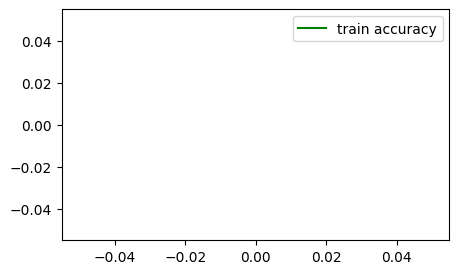

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

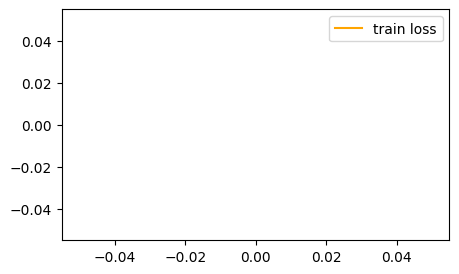

In [ ]:
plt.figure(figsize=(5, 3))
plt.plot(train_loss, color='orange', label='train loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [ ]:
accuracy_1 = my_accuracy(vgg16, testloader)
accuracy_1

Accuracy of the network on the test images: 0 %


0